# TP 2: Reconstruction tomographique

### Par Mathieu Marquis, Charles-Antoine Parent et Thomas Piuze

In [66]:
import numpy as np
import scipy as sp

from devoirs.tp2 import geo, util, CTfilter, recon

## Questions:

### 1- Supposons, pour simplifier, que le corps humain est fait d’eau pure. Grâce à la base de données XCOM du NIST, trouvez le $\mu$ de l’eau pour des photons de 60 keV, à une masse volumique de 1.0 g/cm $^3$. Quelle fraction du signal subsiste après avoir traversé 5 cm d’eau ; 20 cm d’eau ?

Selon les données XCOM du NIST, l'atténuation totale dans l'eau pour des photons de 60 keV est de $2.059\times10^{-1}$ cm $^2$ /g. En multipliant cette atténuation par la masse volumique de l'eau, on obtient un coefficient d'atténuation linéaire de $2.059\times10^{-1}$ cm $^{-1}$. Puisque ce coefficient est une constante et non une fonction de la distance $x$ parcourue, l'intensité en fonction de $x$ est:
$$ I(x) = I_0e^{-\int_0^x\mu(x')dx'} = I_0e^{-\mu\int_0^xdx'} = I_0e^{-\mu x} \longrightarrow \frac{I(x)}{I_0} = e^{-\mu x} $$ 
Après avoir traversé 5 cm et 20 cm d'eau, la fraction subsistante du signal est:
$$ \frac{I(5)}{I_0} = e^{-2.059\times10^{-1}\ \cdot\ 5} \approx 35.72\% \\
\frac{I(20)}{I_0} = e^{-2.059\times10^{-1}\ \cdot\ 20} \approx 1.628\% $$

### 2- En utilisant le code fourni (ou pas), créer une rétroprojection simple, aussi appelée *laminogramme*, des données de projection fournies. Notez qu’une approche par *slicing* pourrait accélérer votre algorithme. Votre code utilisera la méthode du plus proche voisin pour déterminer la valeur de projection à utiliser (le rayon passant par la source et le voxel d’intérêt n’aboutit pas nécessairement au centre des pixels du détecteur). 

### Une fois que vous aurez accès au fantôme numérique, comparez-le à la reconstruction. Qualitativement, quelles différences observez-vous entre l’image reconstruite et l’image de référence (fantôme) ?

Pour chaque voxel, il faut déterminer la distance $d$ par rapport au centre du détecteur à laquelle parvient un rayon partant du voxel considéré et qui frappe le détecteur à un angle de 90 degrés. En exprimant la position des voxels par rapport à l'isocentre à l'aide des coordonnées polaires $r$ et $\phi$, on trouve à l'aide d'un peu de géométrie que cette distance $d$ est:
$$ d = r\cos(\phi-\theta) $$
où $\theta$ est l'angle de la projection.

nbprj: 720
angles min and max (rad):
[0.008726646259971648, 6.283185307179586]


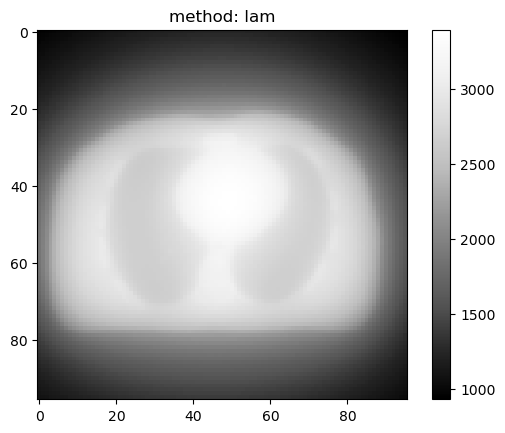

In [67]:
def intensite(
        r: float,
        phi: float
) -> float:
    angles = recon.readInput()[1]
    d = r*np.cos(phi-angles)
    nb_pixels = d//geo.pixsize
    pixel = (geo.nbpix/2+nb_pixels).astype(int)
    intensite = recon.readInput()[2][:][pixel]
    return np.sum(intensite)

#print(intensite(2, 3, recon.readInput()[1]))

def laminogram(backproject = False):
    [nbprj, angles, sinogram] = recon.readInput()
    if backproject is True:
        CTfilter.filterSinogram(sinogram)
    image = np.zeros((geo.nbvox, geo.nbvox))
    a = np.indices((geo.nbvox, geo.nbvox))[0]
    b = np.indices((geo.nbvox, geo.nbvox))[1]
    x = -(b-0.5*(geo.nbvox-1))*geo.voxsize # Pourquoi le moins????????
    y = (a-0.5*(geo.nbvox-1))*geo.voxsize
    r = np.sqrt(x**2+y**2)
    phi = np.arctan2(y, x)
    for a in range(len(angles)):
        d = r*np.cos(phi-angles[a])
        nb_pixels = d//geo.pixsize
        pixel = (geo.nbpix/2+nb_pixels).astype(int)
        image += sinogram[a][pixel]

    # angles2 = np.array(angles)
    # image = np.array(intensite(r, phi, angles2))
    # image = np.array(list(map(intensite, r, phi)))

    util.saveImage(image, "lam")

laminogram()

Le code est Z8HA9!!!!!!

### 3- En utilisant la librairie `numpy.fft`, implémentez le filtre passe-haut proposé pour filtrer le sinogramme une projection à la fois. Affichez et sauvegardez l’image du sinogramme filtré. Qualitativement, quelles sont les principales différences entre le sinogramme fourni et filtré ?

nbprj: 720
angles min and max (rad):
[0.008726646259971648, 6.283185307179586]


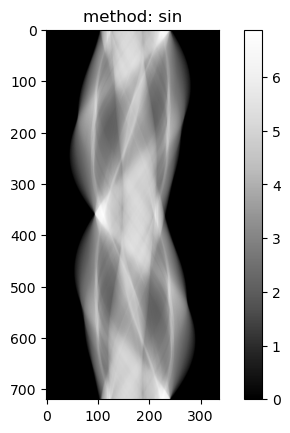

In [68]:
sinogram = recon.readInput()[2]
util.saveImage(sinogram, "sin")

nbprj: 720
angles min and max (rad):
[0.008726646259971648, 6.283185307179586]


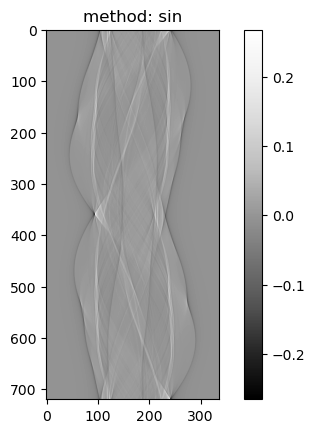

In [69]:
sinogram = recon.readInput()[2]
CTfilter.filterSinogram(sinogram)
util.saveImage(sinogram, "sin")

### 4- Ayant en main le sinogramme filtré, effectuez une rétroprojection filtrée, en récupérant idéalement le code précédent du laminogramme. Comparez l’image obtenue avec le fantôme. Quelles différences observez-vous ? Où sont situées les erreurs et que diriez- vous de la fréquence spatiale des erreurs ?

nbprj: 720
angles min and max (rad):
[0.008726646259971648, 6.283185307179586]


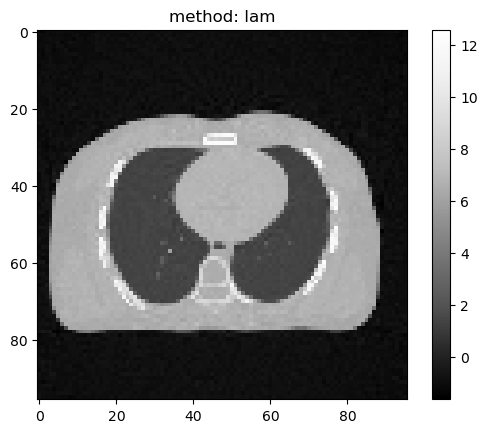

In [70]:
laminogram(backproject=True)

### 5- Écrivez une nouvelle fonction de reconstruction `reconFourierSlice()` qui effectue la reconstruction via le théorème de la tranche de Fourier. Il faut effectuer la TF 1D de chaque projection du sinogramme et stocker le nouveau sinogramme transformé. Par échantillonnage du sinogramme, remplissez l’espace de Fourier 2D de l’image à reconstruire. Vous pouvez choisir l’angle approprié par la méthode du plus proche voisin et la position sur le détecteur par interpolation linéaire. Trouvez l’image par TF $^{-1}_{2D}$ et commentez les résultats. Indice : considérez toutes les données comme des nombres complexes avec l’initialisation suivante `mymatrix = numpy.zeros((a,b), ’complex’)`, puis prenez la partie réelle de l’image finale.

nbprj: 720
angles min and max (rad):
[0.008726646259971648, 6.283185307179586]


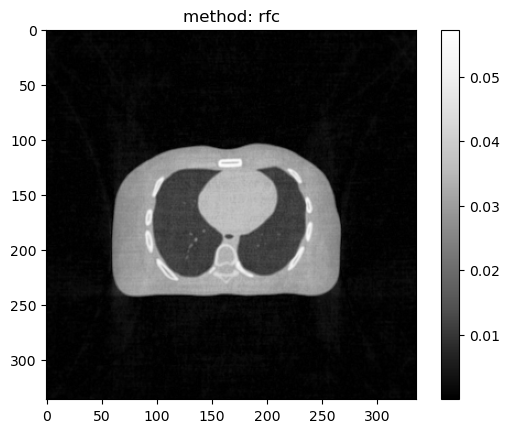

In [71]:
def reconFourierSlice(nbvox: int=geo.nbpix):
    _, angles, sinogram = recon.readInput()

    sinogram_fft = np.fft.fftshift(np.fft.fft(np.fft.ifftshift(sinogram, axes=1)), axes=1)

    r, theta = np.arange(-geo.nbpix/2, geo.nbpix/2), np.pi - angles
    r, theta = np.meshgrid(r, theta)

    # Points de la grille polaire correspondant aux valeurs de la fft du sinogramme
    points = np.stack([(geo.nbpix / 2 + r*func(theta)).flatten() for func in [np.sin, np.cos]], axis=1)

    # Points de la grille d'image où échantillonner la fft du sinogramme
    grid_x, grid_y = np.meshgrid(np.arange(nbvox), np.arange(nbvox))

    # Interpolation sur les données du sinogramme (converties de polaire à cartésien) pour trouver la valeur des pixels
    # de la grille d'image
    fft2 = sp.interpolate.griddata(
        points,
        sinogram_fft.flatten(),
        (grid_y.flatten(), grid_x.flatten()),
        method="linear",
        fill_value=0,
    ).reshape((nbvox, nbvox))

    reconstruction = np.abs(np.real(np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(fft2)))))

    util.saveImage(reconstruction, "rfc")


reconFourierSlice()